In [2]:
import folium
import numpy as np
import pandas as pd
import commonFunctions as func
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import plotly.graph_objects as go

In [3]:
pinnaclePoints = pd.read_csv('../pinnaclePoints.txt', sep=',').fillna('')
numPinnaclePoints = len(pinnaclePoints)
maxElevation = pinnaclePoints.elevation.max()
print(f'Number of Pinnacle Points: {numPinnaclePoints}')

faultyPinnacles = pd.read_csv('../dataSources/generatedDatasets/faultyPinnaclePoints.txt', sep=',')
faultyIds = faultyPinnacles.idFalse.values

Number of Pinnacle Points: 885


In [5]:
'''
Colours pinnacle point markers on the map based on elevation
'''
def getPinnaclePointColor(elevation):
    
    # Defining colors for colormap
    colors = [
        (0.0, 'limegreen'),
        (0.25, 'yellow'),
        (0.5, 'orange'),
        (0.75, 'red'),
        (1.0, 'indigo')
    ]

    # Create the colormap
    colormap = LinearSegmentedColormap.from_list('custom_colormap', colors)
    rgbaColor = colormap(elevation/maxElevation)
    
    # Convert RGBA to HEX
    hexColor = "#{:02x}{:02x}{:02x}".format(
        int(rgbaColor[0] * 255), # Red
        int(rgbaColor[1] * 255), # Green
        int(rgbaColor[2] * 255)  # Blue
    )
    
    return hexColor

'''
Adds a summit to the pinnacle point map
'''
def addPointToMap(summit):
    
    isFaulty = False
    summitCorrection = faultyPinnacles.query('idFalse == @summit.name')
    if len(summitCorrection) > 0:
        isFaulty = True

    summitTitle = summit.summit_name
    summitTitleHTML = ''
    if summitTitle != '':
        summitTitleHTML = f'<b>{summitTitle}</b><br>'
    
    # Building toolTip
    wikiHTML = ''
    if summit.wikipedia != '':
        wikiHTML = f'<a href=https://en.wikipedia.org/wiki/{summit.wikipedia.replace(" ","_")}>Wikipedia</a> | '
        
    latRounded = round(summit.latitude, 4)
    lngRounded = round(summit.longitude, 4)
    toolTip = (f'{summitTitleHTML}' + 
               f'Elevation: {round(summit.elevation)} m<br>' +
               f'Location: {latRounded}, {lngRounded}<br>' + 
               f'Link: {wikiHTML}' + 
               f'<a href=https://www.peakbagger.com/search.aspx?tid=R&lat={latRounded}&lon={lngRounded}&ss=>PeakBagger</a>')
        
    if isFaulty:
            
        nameTrue = summitCorrection.nameTrue.values[0]
        latitudeTrue = summitCorrection.latitudeTrue.values[0]
        longitudeTrue = summitCorrection.longitudeTrue.values[0]
        elevationTrue = summitCorrection.elevationTrue.values[0]
        faultyReason = summitCorrection.reason.values[0]
    
        # Reason 2 does not have have a true point
        if faultyReason != 2:
            summitColor = getPinnaclePointColor(summitCorrection.elevationTrue.values[0])
            summitOpacity = 1
        else:
            summitColor = getPinnaclePointColor(summit.elevation)
            summitOpacity = 0

        marker = folium.RegularPolygonMarker(
            location = [summit.latitude, summit.longitude],
            number_of_sides=3,
            radius = 11,
            fill = True,
            fill_color = summitColor,
            fill_opacity = 0,
            opacity=0.5
            weight = 1,
            color = summitColor,
            gradient = False,
            rotation = 30
        ).add_to(pinnaclePointMap)

        # For better usability on mobile
        invisibleCircleFalse = folium.CircleMarker(
            location = [summit.latitude, summit.longitude],
            radius = 12,
            fill = True,
            fill_opacity = 0,
            weight = 0
        ).add_to(pinnaclePointMap)
        
        if faultyReason == 0:
            toolTipFalse = toolTip + f'<br><br>Falsely identified because<br>Source 1 and/or 2 does not<br>list this summit as shorter than<br>{nameTrue}'
            
        elif faultyReason == 1:
            toolTipFalse = toolTip + f'<br><br>Falsely identified because<br>Source 1 and 2 are missing<br>{nameTrue}'

        elif faultyReason == 2:
            toolTipFalse = toolTip + f'<br><br>Falsely identified because<br>Source 2 lists this elevation<br>as far too large'
            
        elif faultyReason == 3:
            toolTipFalse = toolTip + f'<br><br>Falsely identified because<br>of a manmade object at this<br>location'
            
        invisibleCircleFalse.add_child(folium.Popup(toolTipFalse, max_width=300).add_to(invisibleCircleFalse))
            
        # Reason 2 doeas not have have a true point
        if faultyReason != 2:
            
            # Adding a line to the true summit for misidentifications
            faultToTrueLine = [[summit.latitude, summit.longitude], [summitCorrection.latitudeTrue, summitCorrection.longitudeTrue]]
            folium.PolyLine(faultToTrueLine, color=summitColor, weight=1, opacity=1).add_to(pinnaclePointMap)
            
            markerTrue = folium.RegularPolygonMarker(
                location = [latitudeTrue, longitudeTrue],
                number_of_sides=3,
                radius = 11,
                fill = True,
                fill_color = summitColor,
                fill_opacity = 1,
                weight = 1,
                color = 'black',
                gradient = False,
                rotation = 30
            ).add_to(pinnaclePointMap)

            # For better usability on mobile
            invisibleCircleTrue = folium.CircleMarker(
                location = [latitudeTrue, longitudeTrue],
                radius = 12,
                fill = True,
                fill_opacity = 0,
                weight = 0
            ).add_to(pinnaclePointMap)  

            toolTipTrue = (f'<b>{nameTrue}</b><br>' + 
                           f'Elevation: {elevationTrue} m<br>' +
                           f'Location: {latitudeTrue}, {longitudeTrue}<br>' + 
                           f'Link: <a href=https://www.peakbagger.com/search.aspx?tid=R&lat={latitudeTrue}' + 
                           f'&lon={longitudeTrue}&ss=>PeakBagger</a>')

            invisibleCircleTrue.add_child(folium.Popup(toolTipTrue, max_width=300).add_to(invisibleCircleTrue))
                    
    # Regular non-faulty points
    else:
    
        marker = folium.RegularPolygonMarker(
            location = [summit.latitude, summit.longitude],
            number_of_sides=3,
            radius = 11,
            fill = True,
            fill_color = getPinnaclePointColor(summit.elevation),
            fill_opacity = 1,
            weight = 1,
            color = 'black',
            gradient = False,
            rotation = 30
        ).add_to(pinnaclePointMap)

        # For better usability on mobile
        invisibleCircle = folium.CircleMarker(
            location = [summit.latitude, summit.longitude],
            radius = 12,
            fill = True,
            fill_opacity = 0,
            weight = 0
        ).add_to(pinnaclePointMap)
        invisibleCircle.add_child(folium.Popup(toolTip, max_width=300).add_to(invisibleCircle))
    
summits = pinnaclePoints.sort_values('elevation', ascending=True)
pinnaclePointMap = folium.Map(location=[0, 0], zoom_start=3, tiles=None, world_copy_jump=True)

folium.raster_layers.TileLayer(name = 'Satellite',
                               maxZoom = 17,
                               tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', 
                               attr = 'Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, GIS User Community'
                              ).add_to(pinnaclePointMap)
folium.TileLayer(
          'https://{s}.tile.opentopomap.org/{z}/{x}/{y}.png', 
          attr = 'Map data: &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, <a href="http://viewfinderpanoramas.org">SRTM</a> | Map style: &copy; <a href="https://opentopomap.org">OpenTopoMap</a> (<a href="https://creativecommons.org/licenses/by-sa/3.0/">CC-BY-SA</a>)',
          name = 'Elevation',
          maxZoom = 16
          ).add_to(pinnaclePointMap)
folium.TileLayer(name = 'Street').add_to(pinnaclePointMap)

folium.LayerControl().add_to(pinnaclePointMap)

summits.apply(addPointToMap, axis=1)

legend_html = """
    <div style="
        background-color: rgba(255, 255, 255, 0.9);
        padding: 5px;
        font-size: 12px;
        position: absolute;
        top: 12px;
        right: 70px;
        z-index: 1000;
    ">
        <div style="display: flex; align-items: center; cursor: pointer;" title="Legend" onclick="toggleLegend()">
            <div id="chevronIcon" style="margin-left: 11px; margin-right: 15px; width: 10px; height: 10px; 
                border-style: solid; border-width: 0 3px 3px 0; transform: rotate(45deg);"></div>
            <h4 style="margin: 0; margin-right: 30px;"><b>Pinnacle Points</b></h4>
        </div>
        <div id="legendContent" style="display: none; margin-top: 5px;">
            <center style="margin-top: 15px; margin-bottom: 15px;">
                Points from which no higher<br>point can be seen. More in<br>the info section.
            </center>
            <p style="margin: 0;">
                <div class="row">
                    <div class="col-1" style="margin-left: 26px; margin-right: 0px; margin-top: -4px">
                        <svg width="14" height="14">
                            <polygon points="0,14 7,1 14,14" fill="black" />
                            <polygon points="1.5,13 7,3.2 12.5,13" fill="indigo" />
                        </svg>
                    </div>
                    <div class="col">
                        <div class="col">Mt. Everest's Elevation</div>
                    </div>
                </div>
            </p>
            <p style="margin: 0;">
                <div class="row">
                    <div class="col-1" style="margin-left: 26px; margin-right: 0px; margin-top: -4px">
                        <svg width="14" height="14">
                            <polygon points="0,14 7,1 14,14" fill="black" />
                            <polygon points="1.5,13 7,3.2 12.5,13" fill="red" />
                        </svg>
                    </div>
                    <div class="col">
                        <div class="col">75% of Mt. Everest</div>
                    </div>
                </div>
            </p>
            <p style="margin: 0;">
                <div class="row">
                    <div class="col-1" style="margin-left: 26px; margin-right: 2px; margin-top: -4px">
                        <svg width="14" height="14">
                            <polygon points="0,14 7,1 14,14" fill="black" />
                            <polygon points="1.5,13 7,3.2 12.5,13" fill="orange" />
                        </svg>
                    </div>
                    <div class="col">
                        <div class="col">50% of Mt. Everest</div>
                    </div>
                </div>
            </p>
            <p style="margin: 0;">
                <div class="row">
                    <div class="col-1" style="margin-left: 26px; margin-right: 2px; margin-top: -4px">
                        <svg width="14" height="14">
                            <polygon points="0,14 7,1 14,14" fill="black" />
                            <polygon points="1.5,13 7,3.2 12.5,13" fill="yellow" />
                        </svg>
                    </div>
                    <div class="col">
                        <div class="col">25% of Mt. Everest</div>
                    </div>
                </div>
            </p>
            <p style="margin: 0;">
                <div class="row">
                    <div class="col-1" style="margin-left: 26px; margin-right: 2px; margin-top: -4px">
                        <svg width="14" height="14">
                            <polygon points="0,14 7,1 14,14" fill="black" />
                            <polygon points="1.5,13 7,3.2 12.5,13" fill="limegreen" />
                        </svg>
                    </div>
                    <div class="col">
                        <div class="col">Sea Level</div>
                    </div>
                </div>
            </p>
        </div>
    </div>

    <script>
        function toggleInfoWindow() {
            var infoWindow = document.getElementById("infoWindow");
            var infoIcon = document.getElementById("informationIcon");

            if (infoWindow.style.display === "block") {
                infoWindow.style.display = "none";
                infoIcon.style.fill = "rgba(255, 255, 255, 0.9)";
            } else {
                infoWindow.style.display = "block";
                infoIcon.style.fill = "rgba(255, 255, 0, 0.9)";
            }
        }
    </script>

    <script>
        function toggleLegend() {
            var contentDiv = document.getElementById("legendContent");
            var chevronIcon = document.getElementById("chevronIcon");

            if (contentDiv.style.display === "block") {
                contentDiv.style.display = "none";
                chevronIcon.style.transform = "rotate(45deg)";
            } else {
                contentDiv.style.display = "block";
                chevronIcon.style.transform = "rotate(225deg)";
            }
        }
    </script>
"""

pinnaclePointMap.get_root().html.add_child(folium.Element(legend_html))

pinnaclePointMap.get_root().html.add_child(folium.Element('''
    <div id="catalogue" style="position: absolute; bottom: 94px; right: 4px; cursor: pointer; z-index: 1001;">
        <a href="guide/">
            <svg id="catalogueIcon" width="50" height="50" viewBox="0 0 50 50" fill="white" stroke="black"
                stroke-linecap="round" stroke-linejoin="round" style="fill: rgba(255, 255, 255, 0.9)">
                <title>Guide</title>
                <circle cx="24" cy="24" r="20" stroke-width="6" ></circle>
                <rect x="16" y="15" width="16" height="19" stroke-width="2" fill="none"></rect>
                <rect x="19" y="15" width="13" height="19" stroke-width="2" fill="none"></rect>
                <line x1="23" y1="21" x2="28" y2="21" stroke-width="2"></line>
            </svg>
        </a>
    </div>
'''))

pinnaclePointMap.get_root().html.add_child(folium.Element('''
    <div id="infoIcon" style="position: absolute; bottom: 0px; right: 0px; cursor: pointer; z-index: 1001;">
        <svg id="informationIcon" width="100" height="100" viewBox="0 0 50 50" fill="white" stroke="black" stroke-width="4" 
            stroke-linecap="round" stroke-linejoin="round" onclick="toggleInfoWindow()" style="fill: rgba(255, 255, 255, 0.9)">
            <title>Info</title>
            <circle cx="24" cy="24" r="20"></circle>
            <line x1="24" y1="32" x2="24" y2="24"></line>
            <line x1="24" y1="16" x2="24" y2="16"></line>
        </svg>
    </div>
    <div id="infoWindow" style="display: none; overflow-y: auto; position: absolute; top: 50%; left: 50%; 
        transform: translate(-50%, -50%); background-color: rgba(255, 255, 255, 0.9); padding: 12px; width: 95%; 
        height: 68%;  z-index: 1000;">
        
        <h2>Definitions</h2>
        <p>
            <b>Pinnacle points</b> are a points from which no higher elevation point can be seen. Across the globe, 
            885 have been found. These are all pinnacle points with more than 300 m (~1000 ft) of prominence or more than 
            160 km (~100 miles) of isolation. The curvature of the Earth, atmospheric refraction, and local topography are taken 
            into account. Two summits are defined to have line-of-sight if light can theoretically travel from one to the 
            other under ideal atmospheric conditions. For more, refer to the 
            <a href="guide/screens/what_is_pinnacle_point/">What is a Pinnacle Point?</a> page.</p>
        <p>
            <b>Prominence</b> is the minimum vertical distance one must descend to reach a higher point.
        </p>
        <p>
            <b>Isolation</b> is the distance to the nearest higher point.
        </p>
        <p>
            <b>Atmospheric refraction</b> is the bending of light in the atmosphere due to varying temperatures and pressures.
        </p>
        <p>
            <b>Local topography</b> is the specific shape of the terrain surrounding a point.
        </p>
        
        <h2>Links</h2>
        <li>
            <a href="guide/">
                My journal of summitted pinnacle points
            </a>
        </li>
        <li>
            <a href="https://github.com/jgbreault/PinnaclePoints">
                My github for pinnacle points
            </a>
        </li>
        <li>
            <a href="misc/pinnaclePointAlgorithmExplained.txt">
                An explanation of the algorithm used to find pinnacle points
            </a>
        </li>
        <li>
            <a href="https://www.rhsoc.uk/blog/hill-list-updates/two-classification-criteria-for-the-hills-and-mountains-of-britain/">
                An article by the Relative Hills Society on OTOTWs and pinnacle points
            </a>
        </li>
        <li>
            <a href="guide/screens/contact/">
                Contact me
            </a>
        </li>
        
        <h2>Data Sources</h2>
        <h4><a href="https://www.andrewkirmse.com/prominence-update-2023">1. Mountains by Prominence</a></h4>
        <p>
            Andrew Kirmse and Jonathan de Ferranti found all 11,866,713 summits on Earth with over 100 ft (~30 m)
            of prominence. I use this dataset to find all pinnacle points with more than 300 m (~1000 ft) of prominence.
        </p>
        <h4><a href="https://www.andrewkirmse.com/true-isolation">2. Mountains by Isolation</a></h4>
        <p>
            Andrew Kirmse and Jonathan de Ferranti found all 24,749,518 summits on Earth with over 1 km (~0.6 miles)
            of isolation. I use this dataset to find all pinnacle points with more than 160 km (~100 miles) of isolation.
        </p>
        <h4><a href="https://ototwmountains.com/">3. On-Top-Of-The-World Mountains</a></h4>
        <p>
            An on-top-of-the-world mountain (OTOTW) is a summit where no land rises above the horizontal plane from the summit. 
            Since any land that rises above the horizontal plane would have higher elevation than the summit itself, if a summit 
            is not an OTOTW then it can not be a pinnacle point either. In other words, pinnacle points are a subset of 
            OTOTWs. Kai Xu found all 6,464 OTOTWs on Earth with over 300 m (~1000 ft) of prominence. 
            I identify which of these 6,464 summits are pinnacle points.
            Andreas Geyer-Schulz deserves mention as well for his
            <a href="https://nuntius35.gitlab.io/extremal_peaks/">extremal peaks</a>.
        </p>
        <h4><a href="https://aty.sdsu.edu/explain/atmos_refr/horizon.html">4. Atmospheric Refraction</a></h4>
        <p>
            The exact path light takes in the atmosphere depends on many factors. However, according to the San Diego State 
            University, a ray's path can be approximated as the arc of a circle with radius seven times greater than Earth's. 
            I use this when determining if two summits have line-of-sight.
        </p>
        <h4><a href="https://aty.sdsu.edu/explain/atmos_refr/horizon.html">5. Open-Meteo and Copernicus</a></h4>
        <p>
            Open-Meteo provides a free elevation API that uses the  
            <a href="https://doi.org/10.5270/ESA-c5d3d65">Copernicus DEM</a>. I use this API to find the elevation 
            of points that are not in any of my datasets.
        </p>
        
        <h2>Sources of Error</h2>
        <ol>
            <li>
                The Earth is approximated as a sphere instead of an ellipsoid. This is done for simpler math.
            </li>
            <li>
                There is some inherent error in the data. The datasets have resolutions ranging from of 
                30 m (1 arcsecond) to 90 m (3 arcseconds). All data sources are surface elevation models, 
                so trees and buildings are included.
            </li>
            <li>
                Only 100 equidistant points are sampled when determining if two summits have an obstructed line-of-sight. 
                Some points that could block line-of-sight may not be captured in this sample. 
                By increasing the number of sampled points, more pinnacle points could be found.
            </li>
            <li>
                The algorithm assumes there to be no land below sea level, which is not quite true. 
                Any pinnacle points below sea level would not have been identified. It is possible for some identified 
                pinnacle points that are near basins below sea level to not truly be pinnacle points. This is because these points
                can see farther across their basin in reality than they could if the basin did not descend below sea level.
            </li>
            <li>
                Only summits with more than 300 m (~1000 ft) of prominence or more than 160 km (~100 miles) of isolation 
                are considered. The promience threshold is determined by the OTOTWs dataset since I only consider points 
                in Source 1 that are OTOTWs. When finding pinnacle points in Source 2, high isolation points are obvious
                strong candidates when identifying pinnacle points. The specific value for the isolation threshold 
                was decided arbitarily. Computation time increases considerably as the isolation threshold is lowered.
            </li>
            <li>
                To take atmospheric refraction into account, light rays are approximated as arcs of circles (Source 4). 
                The path light takes in the atmosphere is in fact much more complex and depends on many factors.
                Since the distance you can see from a given point depends on temperature and pressure, 
                the distance you can see from a point technically changes with the seasons and even the time of day. 
                Additionally, the approximation of light following the arc of a circle only holds true 
                for altitudes that are small compared to the 8 km height of the 
                <a href="https://aty.sdsu.edu/explain/thermal/hydrostatic.html#homog">homogeneous atmosphere</a>. 
                This project is slightly outside of this scope.
            </li>
        </ol>
        
        <h2>App Download</h2>
        <p>
            Since the app is only available by downloading the APK, only Android devices are currently supported. 
            Follow these steps to get the app on your Android device:
            <ol>
                <li>Open <a href="https://github.com/jgbreault/PinnaclePoints/blob/main/misc/pinnaclePoints.apk">this page</a> 
                    on your Android device.</li>
                <li>Click the button that looks like [<b>...</b>] (three dots).</li>
                <li>Click [<b>Download</b>]. Open the APK on your device when it is done downloading. 
                    You may get a message similar to "<i>For your security, 
                    your device is not allowed to install apps from this source</i>". 
                    You'll have to go to your settings and allow unknown installs from this source.
                    I recommend changing this setting back after completing these steps.</li>
                <li>Click [<b>Install</b>].</li>
            </ol>
        </p>
    </div>
'''))

pinnaclePointMap

In [4]:
pinnaclePointMap.save('../index.html')

In [56]:
'''
Finds the closest summits to a given latitude-longitude point
Used to find the index of a point I want to investigate
'''
def findClosestSummitsToPoint(latitude, longitude, summits, num=3):
    summitsCopy = summits.copy()
    summitsCopy['distance'] = summitsCopy.apply(lambda peak: func.geod.line_length([peak.longitude, longitude], 
                                                                                   [peak.latitude, latitude]), axis=1)
    summitsCopy['distance'] = summitsCopy.distance.divide(1000).round(2)
    summitsCopy = summitsCopy[['id', 'latitude', 'longitude', 'elevation', 'distance']]
    print(summitsCopy.nsmallest(num, 'distance').head(num))
    
params = func.getParameters()
# patchDir = params['patch_directory']
# patchDir = '../dataSources/generatedDatasets/prominencePatches'
patchDir = '../dataSources/generatedDatasets/isolationPatches'
patchSize = int(params['patch_size'])
poleLat = func.getPoleLatitude(patchSize)
hasIsolation = eval(params['has_isolation'])
hasIsolation = True

if hasIsolation:
    columnNames = ['id', 'latitude', 'longitude', 'elevation', 'MHD', 'isolation']
else:
    columnNames = ['id', 'latitude', 'longitude', 'elevation', 'MHD']
    
latitudeToTest, longitudeToTest = 44.613, 34.243
summits = pd.DataFrame(func.getPatchSummits(latitudeToTest, longitudeToTest, patchDir, patchSize, poleLat), columns = columnNames)
findClosestSummitsToPoint(latitudeToTest, longitudeToTest, summits)

            id  latitude  longitude  elevation  distance
7967  676774.0   38.9100  -120.0358    2209.50      0.03
8570  696957.0   38.9050  -120.0300    2172.31      0.78
9237  717497.0   38.8958  -120.0083    2136.04      2.88


Higher Summits to Test: 27
36.255833, 117.1075 at 1545 m is in view of
36.9158, 113.8533 at 1564.84 m (1 summits tested)
300 km away


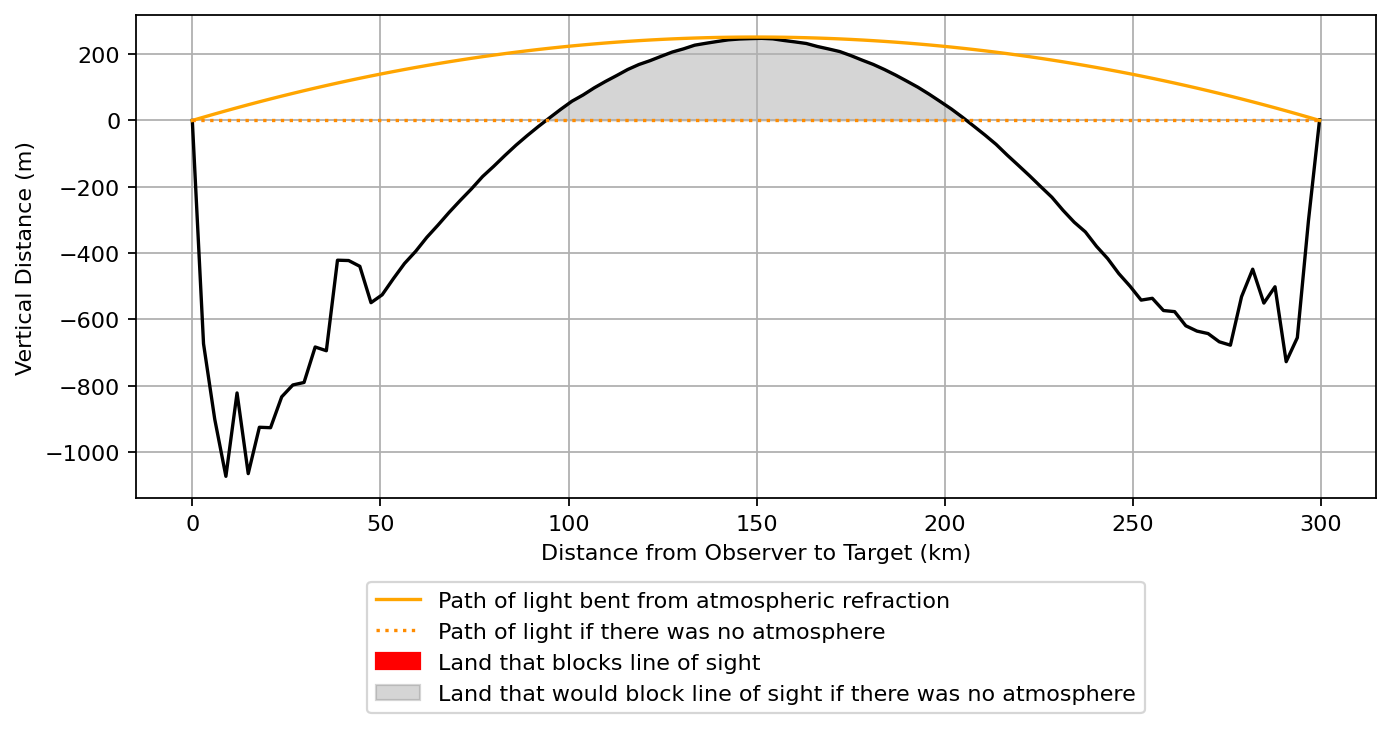

In [6]:
import commonFunctions as func

# patchDir = '../dataSources/generatedDatasets/prominencePatches'
patchDir = '../dataSources/generatedDatasets/isolationPatches'
patchSize = 5
poleLat = 85

isolations = [[459812, 36.255833,117.1075, 1545, func.horizonDistance(1545)]]

for isolation in isolations:
    patchSummits = func.getPatchSummits(isolation[func.LAT], isolation[func.LNG], patchDir, patchSize, poleLat)
    func.isPinnaclePoint(isolation, patchSummits, False, plotClosestInfo=True)

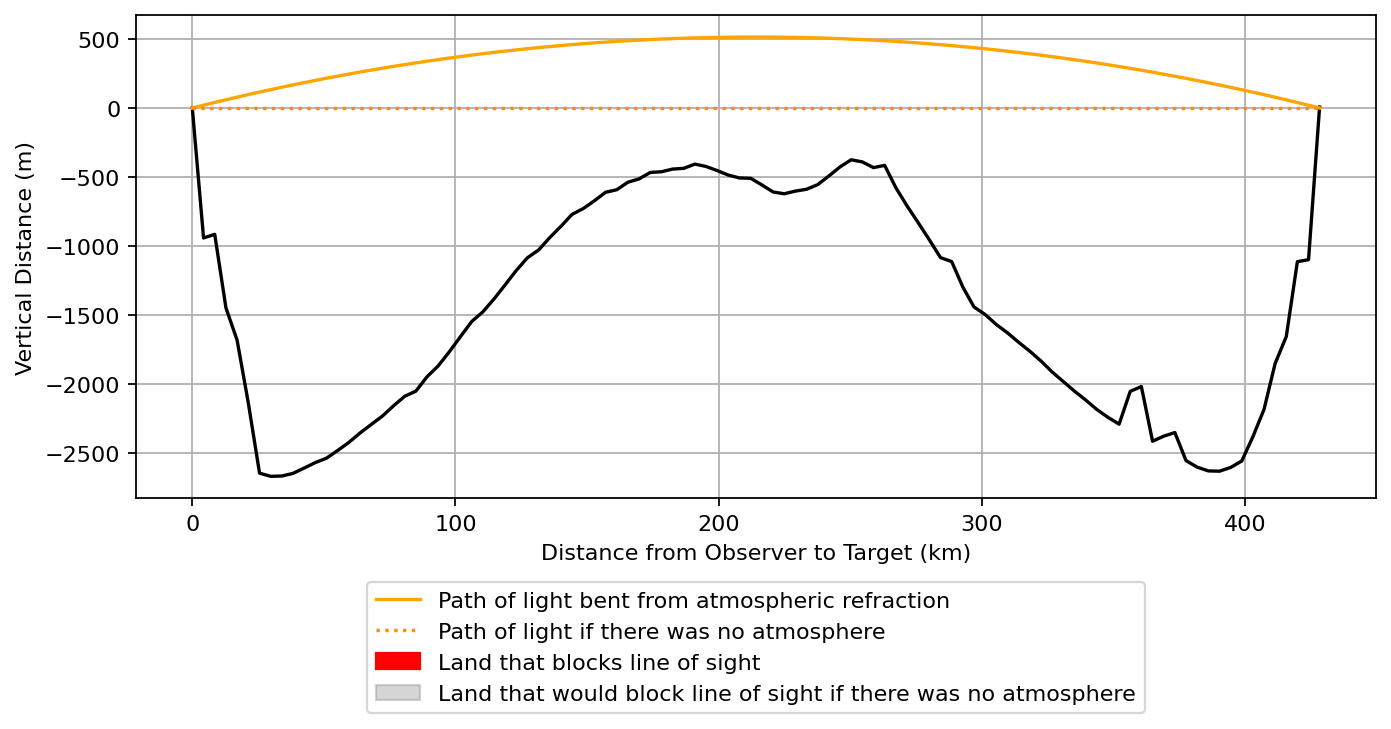

In [35]:
func.plotLosElevationProfile(43.0733, 94.3467, 4885.9400, 
                             39.250965, 93.696361, 5830)

In [2]:
### FINDING MAX LOS ON EARTH
# order all summits by prominence
# find max remaining prominence
# find the patch
# find all summits within MHD(HERO)+MHD(summit)
# check LOS ordered by distance, farthest first
# if LOS is found, log the longest LOS for that point
# save a checkpoint after each new longest LOS
# plot farthest ones on an interactive map!
# just run until I use up my 10,000 daily API calls

### HOW TO PREVENT DUPLICATE LOS TESTS
# Add a tested_ids column to checkpoint
# Whenever a LOS test fails for a summit, I need to add the HERO's ID to the tested_ids of the summit
# When summit is eventually tested, I can skip all IDs in tested_ids

In [31]:
iso_pp = pd.read_csv('../dataSources/generatedDatasets/historicalResults/iso-160km/pinnaclePoints.txt', sep=',').fillna('')

In [32]:
iso_pp = iso_pp.sort_values(by='isolation', ascending=False)

In [17]:
iso_can = pd.read_csv('../dataSources/baseDatasets/isolationSummits/all_iso-160km.txt', sep=',').fillna('')

In [18]:
iso_can = iso_can.sort_values(by='isolation', ascending=False)

In [ ]:
# The most prominent mountin on Earth to not be a pinnacle point
# Nanga Parbat, it can see K2

# The most isolated mountin on Earth to not be a pinnacle point
# Tomort Feng, it can see Altun Shan